# Exp011: Corpus Rule Detection
For a good external validation, each rule is searched for in the corpus and marked if there is at least 80% precision among the hits. If there are less than 5 hits in the first ten examples, the rule is skipped, otherwise 10 more appear.

In [1]:
import pandas as pd
import numpy as np
from torch import save, load, no_grad
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import json
import sys
sys.path.append('../source')
import models
import data
import helpers
import api
#import importlib
#importlib.reload(models)

[nltk_data] Downloading package punkt to
[nltk_data]     /cluster/scratch/dglandorf/cache...
[nltk_data]   Package punkt is already up-to-date!


Load datasets

In [3]:
# egp instances
egp_examples = pd.read_json("../data/egp_gpt35.json")
# load corpus sentences and prepare dataloader
sentences = data.get_mixed_sentences(100000)
encoded_inputs = models.bert_tokenizer(sentences, return_tensors='pt', max_length=64, padding='max_length', truncation=True)
dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

100%|███████████████████| 4/4 [00:37<00:00,  9.48s/it]


In [3]:
# output dataset
output_path = '../data/coded_corpus_hits_new.json'
coded_instances = pd.DataFrame(columns=['#', 'sentence', 'correct', 'score', 'max_token']) if not os.path.exists(output_path) else pd.read_json(output_path)

for each rule:
- train classifier with existing dataset
- search corpus
- output rule to user
- ask for user input until the precision is clear enough

In [4]:
def get_dataset(positives, negatives, others, tokenizer, max_len, others_ratio = 3):
    unique_positive = list(set(positives)) # remove duplicates
    unique_negative = list(set(negatives).difference(set(positives))) # remove duplicates and positives
    num_rands = int(others_ratio * len(unique_negative))
    random.shuffle(others)
    sentences = unique_positive + unique_negative + others[:num_rands]
    labels = [1] * len(unique_positive) + [0] * len(unique_negative) + [0] * len(others[:num_rands])
    print(sum(labels) / len(labels))
    return data.SentenceDataset(sentences, labels, tokenizer, max_len)
def get_trained_classifer(positive, negative, others, classifier=models.RuleDetector(models.bert_encoder), num_epochs=3):
    dataset = get_dataset(positive, negative, others, models.bert_tokenizer, 64) 
    train_dataloader, val_dataloader = data.get_loaders(dataset)
    _, accuracy = models.train(classifier, train_dataloader, val_dataloader, num_epochs)
    return classifier, accuracy

# model training
def get_trained_classifer(positive, negative, others, classifier=models.RuleDetector(models.bert_encoder).to(models.device), ratio=1, verbose=True):
    dataset = data.get_dataset(positive, negative, others, models.bert_tokenizer, 64, ratio*len(positive)/len(negative), verbose=verbose) 
    train_dataloader, val_dataloader = data.get_loaders(dataset)
    _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=verbose)
    return classifier, val_metrics
def get_others(egp, nr):
    return [example for sublist in egp.loc[egp['#'] != nr, 'augmented_examples'].to_list() for example in sublist]

In [4]:
def criterion(coded_instances, min_precision=0.8, num_rules=1):
    correct_per_rule = coded_instances.groupby('#')['correct'].mean()
    return len(correct_per_rule[correct_per_rule > min_precision]) > num_rules

In [9]:
metrics = {}

In [32]:
#while not criterion(coded_instances, num_rules=19):
#    rule = egp_examples.iloc[0] # sample random rule
dir = "corpus_training"
for nr in [int(name.replace(".pth","")) for name in os.listdir(f"../models/{dir}")]:
    rule = egp_examples[egp_examples['#']==nr].iloc[0] # sample random rule
    if nr in list(coded_instances['#']): continue
    print(f"{rule['type']}: {rule['Can-do statement']} ({rule['SuperCategory']}: {rule['SubCategory']})")
    print(rule['Example'])

    tries = 0
    classifier, val_metrics = get_trained_classifer(rule['augmented_examples'], rule['augmented_negative_examples'], get_others(egp_examples, rule['#']), ratio=3)
    while val_metrics['precision']<0.75 and tries < 3:
        tries += 1
        classifier, val_metrics = get_trained_classifer(rule['augmented_examples'], rule['augmented_negative_examples'], get_others(egp_examples, rule['#']), num_epochs=None, ratio=3)
    print(val_metrics)
    metrics[nr] = val_metrics
    scores, tokens = models.score_corpus(classifier, dataloader, max_positive=20, max_batches=1000)
    for score, token, sample in zip(scores, tokens, sentences[:len(scores)]):
        if score < 0.5: continue
        if len(coded_instances[coded_instances['#'] == rule['#']]) >= 20: break
        if sample in list(coded_instances[coded_instances['#'] == rule['#']]['sentence']): continue
        user_response = input(f"{sample}")
        new_row = pd.DataFrame({'#': [rule['#']],
             'sentence': [sample],
             'correct': [user_response == '2'],
             'score': [score],
             'max_token': [token]})
        coded_instances = pd.concat([coded_instances, new_row], ignore_index=True)
        coded_instances.to_json(output_path)

USE: Can use 'would' to make polite requests, often in the fixed expression 'would you mind'. (MODALITY: would)
Would you tell me about your room in your next letter, please? 

Would it be possible for you to meet me later that day, around 7? 

I had forgotten I have an appointment with my dentist at that time, so, would you mind if we met at 5 o'clock instead of meeting at 4 o'clock? 

We are supposed to have a barbecue for lunch, would you mind bringing a salad?
0.21015397419891801


100%|█████████████████| 61/61 [00:18<00:00,  3.25it/s]


Training loss: 0.02124075557880073
Val loss: 0.040733451739185966


100%|█████████████████| 61/61 [00:18<00:00,  3.24it/s]


Training loss: 0.01631648345377113
Val loss: 0.024363475345680285


100%|█████████████████| 61/61 [00:18<00:00,  3.24it/s]


Training loss: 0.015603218621242271
Val loss: 0.029921488973627675
{'accuracy': 0.994, 'f1': 0.987, 'precision': 0.973}


  0%|               | 17/5247 [00:02<14:52,  5.86it/s]


Then, which one would you like? 2
How many carats would you like it to be? 2
And would you like to mail it by air? 1
Would you like a tour of the house? 1
How much would you like to change? 1
Would you care to order now, Sir? 2
Would you like to take a look? 1
Would you consider having your parents live with you when they get older? 1
Would you like to go look by the table with me? 1
Would a slight decrease in pay be worth it for a new opportunity for growth? 1
Would you sit here please? 2
Would you like to have dinner with me? 1
What would your colleagues say about you? 1
What would you do without me? 1
Sure, would you like any appetizers today? 1
What day would you prefer? 1
And would you please forward our mail to this address? 2
To what extent would local assembly help sales, did you say? 1
Would you like to make an inspection tour of some factories? 1
What kind of music would you like, a band or recorded music? 1


USE: Can use 'would' as the past form of 'will' in reported clauses. (MODALITY: would)
She accepted the invitation and she said that she would come on the 21st of June. 

I felt better when he said that he would be in Fenerbahce. 

He told me I would like it and he was right!
0.21789383561643835


100%|█████████████████| 59/59 [00:04<00:00, 11.98it/s]


Training loss: 0.29300904833668273
Val loss: 0.07446992661183079


100%|█████████████████| 59/59 [00:04<00:00, 12.15it/s]


Training loss: 0.04505866375688653
Val loss: 0.03570670139354964


100%|█████████████████| 59/59 [00:04<00:00, 12.15it/s]


Training loss: 0.029837612512568803
Val loss: 0.025157694797962905


100%|█████████████████| 59/59 [00:04<00:00, 12.09it/s]


Training loss: 0.022961025826250186
Val loss: 0.02373468204556654
{'accuracy': 0.994, 'f1': 0.984, 'precision': 0.969}


  1%|               | 43/5247 [00:06<13:56,  6.22it/s]


I would always be ready to go shopping with you! 1
I would be directly responsible for all of the sales representatives in my department. 1
What would your colleagues say about you? 1
So, that would mean that every month it would just come from my account? 1
Well, considering your qualifications, we believe you would be a suitable candidate. 1
I was worried you would think it was too far to drive. 2
To what extent would local assembly help sales, did you say? 1
I love this house and would be willing to pay the full asking price of three hundred and fifty thousand dollars. 1
I knew you'd do a good job as a manager. 2
I wish I could, but I have to walk the dog and finish cooking so if you would excuse me. 1
Certainly, sir.Would you sign here, please?... 1
I think they would be a threat to those of us that lived on the Earth. 1
I wish I would. 1
But it would only be adding to the existing structure. 1
yes, he said it would be batter for me and for the whole family. 2
I thought it would be

USE: Can use the negative forms of 'would' to talk about willingness in the past. (MODALITY: would)
We had to leave without you because the bus driver wouldn't wait. 

[talking about a guitar] It was all that I wanted in life but my parents would not allow me to buy it.
0.21905572096980008


100%|█████████████████| 59/59 [00:04<00:00, 11.82it/s]


Training loss: 0.14617937878938392
Val loss: 0.04270933637356696


100%|█████████████████| 59/59 [00:04<00:00, 11.96it/s]


Training loss: 0.017574861389683498
Val loss: 0.03545273668132722


100%|█████████████████| 59/59 [00:04<00:00, 11.92it/s]


Training loss: 0.011430115120828751
Val loss: 0.033532629706314765
{'accuracy': 0.994, 'f1': 0.985, 'precision': 0.98}


  1%|▏              | 52/5247 [00:08<13:51,  6.25it/s]


She probably wouldn't even recognize me. 1
It's no use complaining.If we had got enough money, we wouldn't put up with it! 1
What would your colleagues say about you? 1
What would you do without me? 1
To what extent would local assembly help sales, did you say? 1
It wouldn't hurt much to say sorry first. 1
I wouldn't call myself extroverted. 1
So would you say if things don't go your way at work it could easily get you down? 1
I knew you'd do a good job as a manager. 1
I would've never known. 1
I never would have guessed. 1
I wouldn't dream of letting you do that. 1
Certainly, sir.Would you sign here, please?... 1
Who much would that come to? 1
I'd probably freeze my lungs. 1
I knew you would be the best person to ask about this. 1
But wouldn't it be easier to take the shirt back and exchange it for the right size? 1
The sales lady said that even if I eat right, I wouldn't get enough vitamins. 1
If you think I'd ever set foot that inferior restaurant again, you gotta be nuts. 1
I asked

USE: Can use 'would' to talk about habitual actions and events in the past. (MODALITY: would)
[talking about a job that the speaker did last year] In my opinion I worked very hard. I would spend a lot of hours at work. 

[from a story about pirates] At night they would go to the rocky seaside and light a fire in order to deceive the boats and let them crash on the rocks.
0.22055674518201285


100%|█████████████████| 59/59 [00:04<00:00, 11.89it/s]


Training loss: 0.17893571458545798
Val loss: 0.04239586346472303


100%|█████████████████| 59/59 [00:04<00:00, 12.11it/s]


Training loss: 0.02852187684433282
Val loss: 0.014296529065662374


100%|█████████████████| 59/59 [00:04<00:00, 12.08it/s]


Training loss: 0.01512400378962442
Val loss: 0.007002254030279194


100%|█████████████████| 59/59 [00:04<00:00, 12.07it/s]


Training loss: 0.008402815228722736
Val loss: 0.0032313076798648884
{'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0}


  4%|▍             | 186/5247 [00:29<13:22,  6.30it/s]


I would always be ready to go shopping with you! 2
Okay, from now on I would swim three times a week. 2
So, that would mean that every month it would just come from my account? 1
But it would only be adding to the existing structure. 1
I heard that this stock would go up. 1
I was hoping you would come. 1
I asked you whether you would go back to your hometown or not. 1
Well, I know that he would never stab me in the back.But I've seen him double cross other people. 1
I would never be able to do that. 1
He told me that I was wanted on the phone in my dormitory, and that person would call me again several minutes later. 2
But we would meet every two weeks. 1
I wish I would live somewhere which were sunning all year round. 1
I thought I would feel like I was in the lap of Luxury. 1
I thought she would marry a fortune. 1
And how many accounts would I handle? 1
She would never talk about me behind my back or hold a grudge. 1
Oh, no, I'v already made several trips to Guangzhou, this is my fir

FORM: Can form conditional subordinate clause with 'if' + present simple. (CLAUSES: conditional)
It is 3 hours long, and if you want to pass it you will have to study very hard, it is very difficult. 

If you buy a gift for me, please buy a book, because I love to read. 

If you agree, we can go shopping after the film.
0.20631747301079567


100%|█████████████████| 63/63 [00:05<00:00, 11.99it/s]


Training loss: 0.689668900318562
Val loss: 0.10659476718865335


 22%|███▊             | 14/63 [00:01<00:04, 11.24it/s]


KeyboardInterrupt: 

In [33]:

with open("../results/gpt_training_metrics.json", 'w') as f:
    json.dump(metrics, f)

# Analyse coded instances

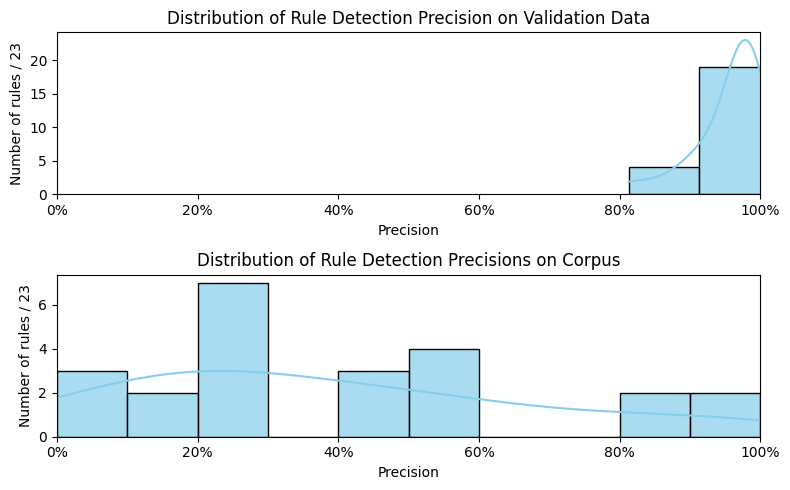

In [4]:
def plot_histogram(ax, data):
    sns.histplot(ax=ax, data=data, binwidth=0.1, kde=True, color="skyblue", edgecolor='black', alpha=0.7, legend=False)
    ax.set_ylabel(f"Number of rules / {len(data)}")
    ax.set_xlabel("Precision")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    ax.set_xlim(0, 1)
    
with open("../results/gpt_training_metrics.json", 'r') as f:
    metrics = json.load(f)
correct_per_rule = coded_instances.groupby('#')['correct'].mean()
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
plot_histogram(axs[0], [m['precision'] for m in metrics.values()])
axs[0].set_title("Distribution of Rule Detection Precision on Validation Data")
plot_histogram(axs[1], list(correct_per_rule))
axs[1].set_title("Distribution of Rule Detection Precisions on Corpus")
plt.tight_layout()
plt.show()

In [7]:
gpt_generated = [np.mean([m['precision'] for m in metrics.values()]), np.mean(correct_per_rule)]

In [14]:
corpus_instances = [0.7550173913043479, 0.6870175146490934] # from exp012

/tmp/ipykernel_1568/3706234907.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


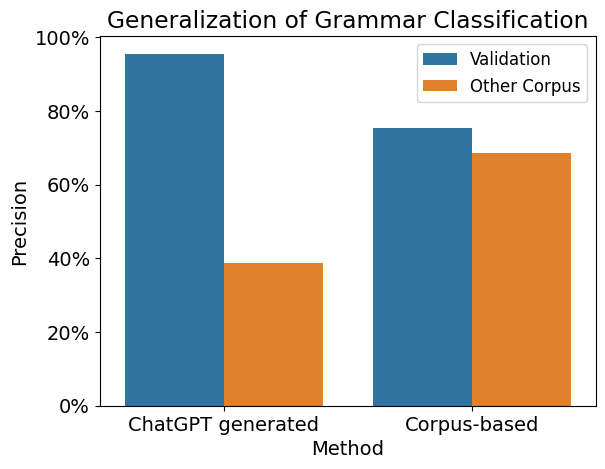

In [28]:
data = {
    'Method': ['ChatGPT generated', 'ChatGPT generated', 'Corpus-based', 'Corpus-based'],
    'Testset': ['Validation', 'Other Corpus', 'Validation', 'Other Corpus'],
    'Precision': gpt_generated + corpus_instances
}

df = pd.DataFrame(data)

# Create the bar plot
sns.barplot(x='Method', y='Precision', hue='Testset', data=df)
plt.rcParams.update({'font.size': 14})
# Adding labels and title
plt.xlabel('Method')
plt.ylabel('Precision')
plt.title('Generalization of Grammar Classification')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])

plt.xticks(fontsize=14)  # Font size for x-tick labels
plt.yticks(fontsize=14)  # Font size for y-tick labels
plt.legend(fontsize=12)  # Font size for legend
# Show the plot
plt.show()